## Homework 3


### Problem 1
1.
A rotor has a rectangular 
blade planform, a solidity of 0.1, ideal blade twist, and operates 
in hover at a thrust coefficient of 0.008. By numerical means, using the combined blade 
element momentum theory (BEMT), compare the predicted inflow ratio across the span of 
the blade with 
the exact (analytic) result (uniform inflow result). Plot a continuous line for 
exact result and points (markers) for the numerical result. Show also the radial distributions of 
thrust,  induced  torque,  lift  coefficient,  and  then  compare  the  solutions  obtained 
using  the exact  theory.  Compare the  numerical  calculations  of  the  integrated  thrust  and  induced 
power with exact results for this rotor over the range $0 < C_T < 0.01$. 

#### Known

* Rectangular ==> $ C(r) = const$
* $\sigma = \frac{N_b C}{\pi R} = 0.1$ 
* Ideal blade twist ==> $\theta(r) = \frac{\theta_{tip}}{r} $
* $C_T = 0.008$

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import bisect, fixed_point # Used later
%matplotlib inline

Define a function to compute the solidity distribution.

In [2]:
def get_solidity(r, sigma_tip, taper='None'):
    """ Return a vector for the solidity variation with respect to r.  """
    sigma = np.ones(r.shape)

    if taper == 'None':
        sigma = sigma * sigma_tip
        
    elif taper == 'Ideal':
        sigma = sigma_tip / r
        
    elif taper == 'Linear':
        sigma = sigma_tip * ( 1-r) * sigma_tip
    else:
        print 'Not a valid option!'
    return sigma
        
        
def test_solidity():
    r = np.linspace(0.2,1)
    sigma_test = 0.1
    get_solidity(r, sigma_test) # Untapered
    get_solidity(r, sigma_test, taper='Ideal')  
    get_solidity(r, sigma_test, taper='Linear')
    print 'Preliminary tests passed.'

test_solidity()
    

Preliminary tests passed.


Define a function to get the twist distribution.

In [3]:
def get_theta(r, theta_tip, twist = 'None'):
    theta = np.ones(r.shape)
    
    if twist == 'None':
        theta = theta * theta_tip
    elif twist == 'Ideal':
        theta = theta_tip / r
    elif twist == 'Linear':
        theta = theta_tip + (1-r) * theta_tip
    else:
        print 'Not a valid option for the blade twist!'
    return theta
        
def test_theta():
    r = np.linspace(0.2,1)
    theta_test = 0.1
    get_theta(r, theta_test)                    # Untwisted
    get_theta(r, theta_test, twist='Ideal')  
    get_theta(r, theta_test, twist='Linear')
    print 'Preliminary tests passed.'
    
test_theta()
        
        

Preliminary tests passed.


Create a 'meshing' function to discretize the blade properly.

In [4]:
# Spanwise discretization
def gen_mesh(ny, e_root, test=False):
    delta_r = (1-e_root) / ny
    boundaries = np.linspace(e_root,1,ny+1)
    midpoints = boundaries[:ny] + (delta_r/2) * np.ones(boundaries[:ny].shape)
    if test:
        print "Boundaries at: "
        print np.linspace(e_root,1,ny+1)
        print "Midpoints at: "
        print midpoints
    return midpoints


def mesh_test():
    gen_mesh(4, 0,test=True)
    
mesh_test()

Boundaries at: 
[ 0.    0.25  0.5   0.75  1.  ]
Midpoints at: 
[ 0.    0.25  0.5   0.75]


Create a function to get the inflow ratio distribution

In [5]:
def inflow_ratio(sigma, theta, r):
    """Returns the inflow ratio, lambda, of a hovering rotor."""
    assert sigma.shape == theta.shape
    assert theta.shape == r.shape
    cl_alpha = 2 * np.pi
#    lambda_ = np.zeros(r.shape)
    lambda_ = (sigma * cl_alpha / 16) * (-1 + np.sqrt(1 + (32 * theta * r)/(sigma * cl_alpha)))
    assert lambda_.shape == r.shape
    return lambda_
    
def inflow_test():
    r = np.linspace(0.1,1)
    sigma = 0.1 * np.ones(r.shape)
    theta = 0.5 * np.ones(r.shape)
    print inflow_ratio(sigma, theta, np.linspace(0.1,1))
    
    
inflow_test()

[ 0.03468357  0.03940919  0.04386663  0.04809695  0.05213169  0.0559957
  0.05970898  0.0632879   0.06674608  0.07009495  0.07334429  0.07650246
  0.07957674  0.08257347  0.08549825  0.08835602  0.09115118  0.09388769
  0.09656907  0.09919855  0.10177901  0.1043131   0.10680324  0.10925164
  0.11166032  0.11403116  0.11636589  0.11866611  0.1209333   0.12316886
  0.12537406  0.12755012  0.12969815  0.13181922  0.13391431  0.13598436
  0.13803024  0.14005278  0.14205276  0.14403092  0.14598796  0.14792454
  0.14984129  0.15173881  0.15361766  0.15547839  0.1573215   0.15914749
  0.16095684  0.16274998]


Create functions to compute the inflow *angle*, and the thrust coefficient for a given geometry.

In [6]:
def get_phi(r, lambda_):
    phi = lambda_/r
    return phi
   

def get_CT(r, sigma, theta, lambda_):
    """ This function computes C_T by numerical integration."""
    phi = get_phi(r, lambda_)
    assert r.shape == theta.shape
    assert theta.shape == lambda_.shape
    C_T = 0.
    delta_r = r[1] - r[0]  # The mesh should be uniform, so this works.
    for ind in xrange(0,len(r)):
        #C_T = C_T + f(r[ind],sigma[ind],theta[ind],phi[ind]) * delta_r
        C_T = C_T + 0.5 * sigma[ind] * 2 * np.pi * (theta[ind] - phi[ind]) * r[ind]**2
    return C_T


def test_phi():
    r = gen_mesh(50,0.)
    C_T = 0.008
    return get_phi(r, np.sqrt(C_T/2))

# This should look like a hyperbola if it works properly.
#
#plt.plot(gen_mesh(50,0.), test_phi())
#plt.title('Test Plot');

In [7]:
# Rectangular blade, ideal twist
ny = 10
e_root = 0.
print 'Theta_{tip} ' + 'C_T'
r = gen_mesh(ny, e_root)
sigma = get_solidity(r,0.1)
CT = 0.008 # Per the problem statement

for index in xrange(0,10): # Testing to see if it's working.
    theta_tip = np.radians(index)
 
    pitch = get_theta(r,theta_tip, twist='Ideal')

    lambda_ = inflow_ratio(sigma, pitch, r)
    
    print index,get_CT(r, sigma, pitch, lambda_)

    
#----------------------------------------------------------
# Using scipy.optimize.bisect to get the theta_tip needed to fix C_T = 0.008

def theta_residual_factory(r, sigma, lambda_, CT, twist_type):
    """
    This factory function is necessary to interface with the scipy functions I need.
    This functions builds a residual function that has a single parameter, 'theta_tip', that
    scipy.optimize.bisect can solve for the roots of.
    """
    def f(theta_tip):
        theta = get_theta(r, theta_tip, twist=twist_type)
        lambda_ = inflow_ratio(sigma,theta, r)  # Missing this earlier
        
        residual = CT - get_CT(r, sigma, theta, lambda_)
        return residual
    return f

residual = theta_residual_factory(r, sigma, lambda_, CT, 'Ideal')
theta_tip = bisect(residual, 0, np.pi/2)

print
print np.degrees(theta_tip)




Theta_{tip} C_T
0 0.0
1 0.00432263397771
2 0.0137077838904
3 0.0258138958938
4 0.0396883337248
5 0.0548311355616
6 0.0709411859211
7 0.0878204716488
8 0.105330534404
9 0.123370055014

1.43772059911


In [8]:
def set_CT(CT, r, sigma, theta, twist_type='Ideal'):
    """
    Pick a value for CT, feed in a blade mesh and geometry, and this function should give
    everything that needs to be plotted.
    """
    lambda_ = inflow_ratio(sigma, theta, r)
    
    def theta_residual_factory(r, sigma, lambda_, CT, twist_type):
        """
        This factory function is necessary to interface with the scipy functions I need.
        This functions builds a residual function that has a single parameter, 'theta_tip', that
        scipy.optimize.bisect can solve for the roots of.
        """
        def f(theta_tip):
            theta = get_theta(r, theta_tip, twist=twist_type)
            lambda_ = inflow_ratio(sigma,theta, r)  # Missing this earlier

            residual = CT - get_CT(r, sigma, theta, lambda_)
            return residual
        return f

    residual = theta_residual_factory(r, sigma, lambda_, CT, twist_type)
    theta_tip = bisect(residual, 0, np.pi/2)  # Returns the angle in radians
    
    pitch = get_theta(r, theta_tip, twist='Ideal')
    lambda_ = inflow_ratio(sigma, pitch, r)
    
    phi = get_phi(r, lambda_)
    alpha = pitch - phi
    cl = alpha * 2 * np.pi
    dCT = 0.5 * sigma * cl * r**2
    dCQ = np.pi/2 * sigma * r**3 * phi * cl
    
    
    return lambda_, dCT, dCQ, cl

set_CT(0.008, r, sigma, pitch) # Testing to see if it works.

(array([ 0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02,  0.02]),
 array([  8.00000000e-05,   2.40000000e-04,   4.00000000e-04,
          5.60000000e-04,   7.20000000e-04,   8.80000000e-04,
          1.04000000e-03,   1.20000000e-03,   1.36000000e-03,
          1.52000000e-03]),
 array([  5.02654825e-06,   1.50796447e-05,   2.51327412e-05,
          3.51858377e-05,   4.52389342e-05,   5.52920307e-05,
          6.53451272e-05,   7.53982237e-05,   8.54513202e-05,
          9.55044167e-05]),
 array([ 0.64      ,  0.21333333,  0.128     ,  0.09142857,  0.07111111,
         0.05818182,  0.04923077,  0.04266667,  0.03764706,  0.03368421]))

**Solution**

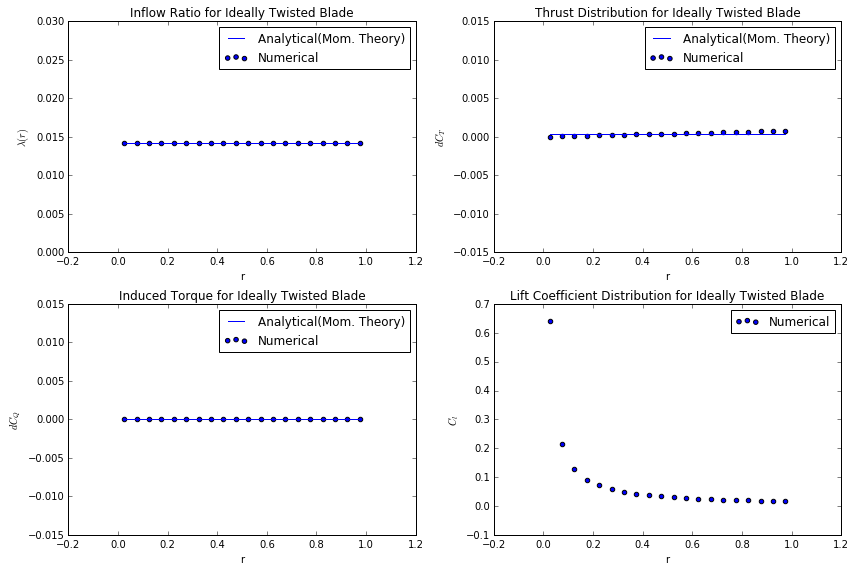

In [9]:
# Rectangular blade, ideal twist
ny = 20
e_root = 0.

r = gen_mesh(ny, e_root)
sigma = get_solidity(r,0.1)
pitch = get_theta(r, 0,twist='Ideal')
CT = 0.008 # Per the problem statement

inflow_n, dCT, dCQ, cl = set_CT(CT, r, sigma, pitch) 

inflow_ana = np.sqrt(CT/(2*ny)) * np.ones(r.shape) # From momentum theory
# Generate the plots
fig, axes = plt.subplots(2,2,figsize=(12,8))

axes[0,0].scatter(r, inflow_n,label='Numerical')
axes[0,0].plot(r, inflow_ana, label='Analytical(Mom. Theory)')
axes[0,0].set_xlabel('r')
axes[0,0].set_ylabel(r'$\lambda(r)$')
axes[0,0].set_title('Inflow Ratio for Ideally Twisted Blade')

axes[0,0].legend(loc=0);

## Thrust Distribution
axes[0,1].scatter(r, dCT,label='Numerical')
axes[0,1].plot(r, CT/ny * np.ones(r.shape), label='Analytical(Mom. Theory)')
axes[0,1].set_xlabel('r')
axes[0,1].set_ylabel(r'$dC_T$')
axes[0,1].set_title('Thrust Distribution for Ideally Twisted Blade')

axes[0,1].legend(loc=0);

## Induced Torque
axes[1,0].scatter(r, dCQ,label='Numerical')
axes[1,0].plot(r, CT/ny * np.ones(r.shape) * np.sqrt(CT/2), label='Analytical(Mom. Theory)')
axes[1,0].set_xlabel('r')
axes[1,0].set_ylabel(r'$dC_Q$')
axes[1,0].set_title('Induced Torque for Ideally Twisted Blade')

axes[1,0].legend(loc=0);


## Lift Coefficient
axes[1,1].scatter(r, cl,label='Numerical')
#axes[1,0].plot(r, CT/ny * np.ones(r.shape) * np.sqrt(CT/2), label='Analytical(Mom. Theory)')
axes[1,1].set_xlabel('r')
axes[1,1].set_ylabel(r'$C_l$')
axes[1,1].set_title('Lift Coefficient Distribution for Ideally Twisted Blade')

axes[1,1].legend(loc=0);



fig.tight_layout()

The $C_l$ plot doesn't seem right.  I expected it to be a constant with respect to r.

### Problem 2

Using
BEMT, implement Prandtl’s tip-loss function. For a rotor of solidity 0.1 and with no 
blade twist, show the effects of the tip-loss effect on the induced inflow, thrust distribution, 
lift coefficient distribution, and torque distribution across the blade span. Neglect profile 
drag  in  this  case.  Compare  the  results  for  rotors  with  2  and  4  blades  at  the  same  thrust 
coefficient of 0.008. Also, calculate the induced power factor (κ) for the two rotors, with 
and without the tip-loss effect and comment on your results.

Tip loss function test


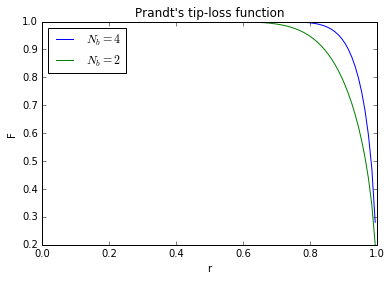

In [11]:
N_b = 4. 

def F(r, phi, nb=4):
    """Prandtl's tip-loss function."""
    def f(r, phi, nb):
        """Exponent of Prandtl's tip-loss function."""
        f = (nb/2) * (np.ones(r.shape) - r) / (r * phi)
        return f
    F = ( 2 / np.pi) * np.arccos(np.exp(-f(r, phi, nb)))
    return F

def F_test():
    r = gen_mesh(100, 0.)
    print 'Tip loss function test'
    plt.plot(r,F(r, 0.1 * np.ones(r.shape),4),label=r'$N_b = 4$')
    plt.plot(r,F(r, 0.1 * np.ones(r.shape),2),label=r'$N_b = 2$')
    plt.legend(loc=0)
    plt.xlabel('r')
    plt.ylabel('F')
    plt.title("Prandt's tip-loss function")
    
F_test()

In [74]:
def inflow_ratio_2(sigma, theta, r, nb):
    """
    Returns the inflow ratio, lambda, of a hovering rotor with tip losses being
    accounted for.
    """
    assert sigma.shape == theta.shape
    assert theta.shape == r.shape
    cl_alpha = 2 * np.pi
    # First guess for lambda_ assumes no tip loss
    lambda_ = inflow_ratio(sigma, theta, r)
    for index in xrange(0,100):
        phi = get_phi(r, lambda_)
        tip_loss = F(r, phi, nb)
        lambda_ = ((sigma * cl_alpha)/(18 * tip_loss)) * (np.sqrt(1 + (32*tip_loss * theta * r)/(sigma * cl_alpha)) - 1)
    
    
    assert lambda_.shape == r.shape
    return lambda_

def inflow_test_2():
    nb = 8
    r = gen_mesh(10,0.)
    return inflow_ratio_2(0.01 * np.ones(r.shape), 0.1 * np.ones(r.shape), r,4)
    
inflow_test_2()

array([ 0.00308298,  0.00676941,  0.00944476,  0.01165468,  0.01358088,
        0.01531077,  0.01689438,  0.01836354,  0.01973997,  0.02108958])

**Solution **

In [75]:
# Rectangular, untwisted, untapered, with 2 blades
nb = 2
ny = 10
sigma_tip_2 = 0.1
CT = 0.008
r = gen_mesh(ny, 0.)
sigma_2 = get_solidity(r, sigma_tip_2)
theta_tip_2 = np.radians(1.635)  # Must change this to drive CT to 0.008 as before
pitch_2 = get_theta(r, theta_tip_2,'None')
lambda_2 = inflow_ratio_2(sigma_2, pitch_2, r, nb)


phi_2 = get_phi(r, lambda_2)
alpha_2 = pitch_2 - phi_2
cl_2 = alpha_2 * 2 * np.pi
dCT_2 = 0.5 * sigma_2 * cl_2 * r**2
dCQ_2 = np.pi/2 * sigma_2 * r**3 * phi_2 * cl_2
rotor2_stuff = lambda_2, dCT_2, dCQ_2, cl_2

# Rectangular, untwisted, untapered, with 4 blades
Nb = 4
sigma_tip_3 = 0.1
sigma_3 = get_solidity(r, sigma_tip_3)
theta_tip_3 = np.radians(1.63)  # Must change this to drive CT to 0.008 as before
pitch_3 = get_theta(r, theta_tip_3,'None')
lambda_3 = inflow_ratio_2(sigma_3, pitch_3, r, Nb)

phi_3 = get_phi(r, lambda_3)
alpha_3 = pitch_3 - phi_3
cl_3 = alpha_3 * 2 * np.pi
dCT_3 = 0.5 * sigma_3 * cl_3 * r**2
dCQ_3 = np.pi/2 * sigma_3 * r**3 * phi_3 * cl_3
rotor3_stuff = lambda_3, dCT_3, dCQ_3, cl_3



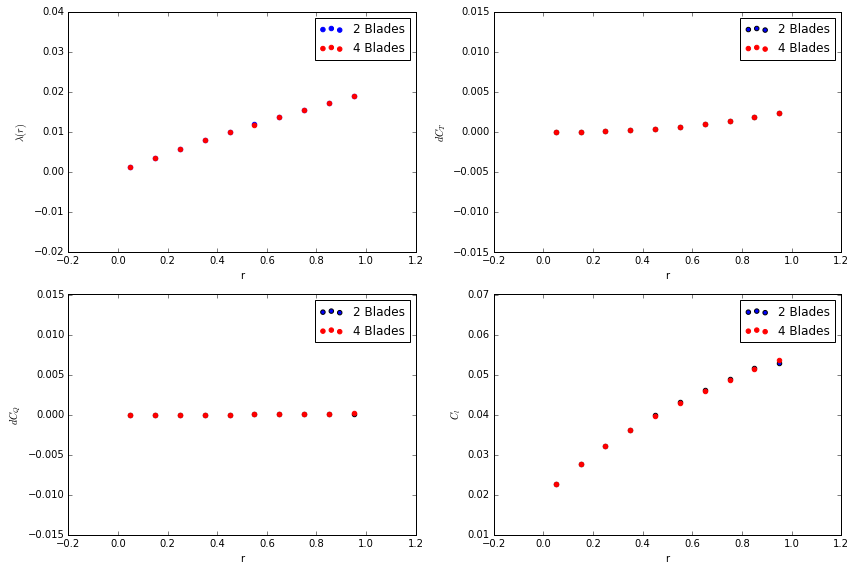

In [77]:
# Generate the plots
fig, axes = plt.subplots(2,2,figsize=(12,8))

axes[0,0].scatter(r, rotor2_stuff[0],label='2 Blades',color='b')
axes[0,0].scatter(r, rotor3_stuff[0],label='4 Blades',color='r')
axes[0,0].set_xlabel('r')
axes[0,0].set_ylabel(r'$\lambda(r)$')

axes[0,0].legend(loc=0);

## Thrust Distribution
axes[0,1].scatter(r, rotor2_stuff[1],label='2 Blades')
axes[0,1].scatter(r, rotor3_stuff[1],label='4 Blades',color='r')
axes[0,1].set_xlabel('r')
axes[0,1].set_ylabel(r'$dC_T$')

axes[0,1].legend(loc=0);

## Induced Torque
axes[1,0].scatter(r, rotor2_stuff[2],label='2 Blades')
axes[1,0].scatter(r, rotor3_stuff[2],label='4 Blades',color='r')
axes[1,0].set_xlabel('r')
axes[1,0].set_ylabel(r'$dC_Q$')

axes[1,0].legend(loc=0);


## Lift Coefficient
axes[1,1].scatter(r, rotor2_stuff[3],label='2 Blades')
axes[1,1].scatter(r, rotor3_stuff[3],label='4 Blades',color='r')
axes[1,1].set_xlabel('r')
axes[1,1].set_ylabel(r'$C_l$')

axes[1,1].legend(loc=0);



fig.tight_layout()

In [88]:
def get_Cp(r, dCQ):
    delta_r = r[1] - r[0]
    Cp = 0.
    for element in dCQ:
        Cp = Cp + delta_r * element
    return Cp

Cp_2 = get_Cp(r, dCQ_2)
Cp_3 = get_Cp(r, dCQ_3)
kappa_2 = Cp_2 * np.sqrt(2/(CT**3))
kappa_3 = Cp_2 * np.sqrt(2/(CT**3))

print 'Induced power factors for 2 blade and 4 blade rotors, respectively.'
kappa_2, kappa_3

Induced power factors for 2 blade and 4 blade rotors, respectively.


(0.078824726415253621, 0.078824726415253621)

Without the tip-loss effects, these Kappa values would be a bit closer to 1.  They cannot reach 1 however since the blades are not twisted.

### Problem 3

Using BEMT, show the effect of increasing linear twist on the variations in inflow, thrust, induced power, profile power and lift coefficient across the span of a rotor with 4 blades of  rectangular planform and solidity 0.1, and  operating  at a thrust coefficient of 0.008. 
Assume Cd= 0.011. Include Prandtl’s tip-loss effects. All of the results should be compared 
at a constant thrust (disk loading).